---

# **Sobre** | Big Data
---

# **Tópicos**

<ol type="1">
  <li>Orientação a coluna;</li>
  <li>Particionamento.</li>
</ol>

---

## 1\. Orientação a coluna

Para obsevar os benefícios que a orientação a coluna trás para o armazenamento de grandes volumes de dados, vamos explorar duas tecnologias orientadas a colunas: o formato de arquivo `Apache Parquet` (disco) e a estrutura de dados `Apache Arrow` (memória). Vamos também compará-las com seus pares orientados a linha, como arquivos do tipo `csv` e o pacote Python Pandas.  

Como exemplo, vamos utilizar os dados de crime da cidade de Chicago, Estados Unidos da América, em 2014. Os dados estão armazenados em um arquivo no formato `csv` de aproimadamente 50MB e foram extraídos do Kaggle ([link](https://www.kaggle.com/yamqwe/chicago-crimee?select=chicago_crime_2014.csv)).

In [3]:
!wget https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/crime.csv -q -O crime.csv

Vamos criar um DataFrame Pandas com os dados.

In [4]:
import pandas as pd

filename = './crime'

df = pd.read_csv(f'./{filename}.csv')

In [ ]:
df.head()

Vamos então conferir alguns metadados do DataFrame.

In [ ]:
df.shape

In [ ]:
df.info()

Por fim, vamos realizar uma agregação para futura comparação. Nela, vamos contar a frequencia de ocorrência dos crimes agrupados localidades da cidade (coluna `Location Description`).

In [ ]:
agg_df = df['Location Description'].value_counts()

In [ ]:
agg_df

### **1.1. Apache Parquet**

O `Apache Parquet` é o formato de arquivo **orientado a coluna** mais utilizado no ecossistema de *big data* ([documentação](https://parquet.apache.org/)). Entre suas funcionalidades, podemos destacar:

  - indexação por coluna (processamento);
  - tipagem por coluna (processamento e armazenamento);
  - compressão por coluna (armazenamento).

A interoperabilidade com o pacote Python `Pandas` é alcançada atrás do uso de estruturas de dados **orientadas a coluna**, como o `Apache Arrow`. Exemplos:

 - Salvando DataFrame `Pandas` para um arquivo `Apache Parquet`:

In [6]:
df.to_parquet('./crime.parquet', engine='pyarrow')

 - Salvando DataFrame `Pandas` para um arquivo `Apache Parquet` comprimido:

In [7]:
df.to_parquet('./crime.parquet.gzip', engine='pyarrow', compression='gzip')

Vamos utilizar o método `getsize` do pacote nativo `os` para estimar o tamanho dos arquivos na memória persistente (ROM/SSD):

In [8]:
import os

extensions = ['csv', 'parquet', 'parquet.gzip']

for extension in extensions:

  size = os.path.getsize(f'{filename}.{extension}')
  size_mb = round(size / 1024 / 1024, 2)

  print(f'{extension}: {size_mb} MB')

csv: 44.72 MB
parquet: 11.66 MB
parquet.gzip: 8.32 MB




> Agora podemos notar uma grande diferença do espaço de armazenamento desses dados



### **1.2. Apache Arrow**

O `Apache Arrow` é o uma estrutura de dados **orientado a coluna** muito utilizada no ecossistema de *big data* ([documentação](https://arrow.apache.org/)). É equivalente ao `Apache Parquet`, mas em memória, como listas, dicionários e objetos Python. O pacote Python `PyArrow` ([documentação](https://arrow.apache.org/docs/python/install.html)) permite a criação e manipulação das estruturas de dados do `Apache Arrow`. 

In [ ]:
!pip install pyarrow==7.0.0

O `PyArrow` trabalha com uma estrutura de dados orientada a coluna conhecida como `table` (tabela), similar aos DataFrames `Pandas`.

In [ ]:
from pyarrow import csv
import pyarrow as pa
import pandas as pd

filename = './crime'

table = csv.read_csv(f'{filename}.csv')
df = pd.read_csv(f'./{filename}.csv')

In [ ]:
table.shape

In [ ]:
table

A similaridade com o Pandas fica evidente quando realizamos operações de agregação.

 - Pandas

In [ ]:
agg_df = df['Location Description'].value_counts()

In [ ]:
agg_df

 - PyArrow

In [ ]:
agg_table = table.group_by('Location Description').aggregate([('Location Description', 'count')])

In [ ]:
agg_table

Vamos utilizar o método `getsizeof` do pacote nativo `sys` para estimar o tamanho dos objetos na memória de trabalho (RAM):

In [ ]:
import sys

objects = [{'pandas': df}, {'pyarrow': table}]

for obj_dict in objects:
  for id, obj in obj_dict.items():
    
    size = sys.getsizeof(obj)
    size_mb = round(size / 1024 / 1024, 2)

    print(f'{id}: {size_mb} MB')

Vemos que o objeto gerado pelo `PyArrow` (`table`) é aproximadamente 3 vezes menor que o objeto (`dataframe`) utilizado `Pandas`.

## 2\. Particionamento

Para obsevar os benefícios que o **particionamento** trás para o armazenamento de grandes volumes de dados, vamos explorar as técnicas de particionamento na *cloud* da AWS, utilizando os serviços AWS S3 e AWS Athena, e o seu efeito combinado com a **orientação a coluna** através do `Apache Parquet`.

### **2.1. Dados**

Vamos criar a coluna `reference_date` a partir da coluna `Date` no formato YYYY-MM-DD e entender se ela será uma boa coluna de partião.

In [ ]:
import pandas as pd

filename = './crime'

df = pd.read_csv(f'./{filename}.csv')

In [ ]:
df.head()

In [ ]:
from datetime import datetime

df['reference_date'] = df['Date'].apply(lambda date: datetime.strptime(date.split(sep=' ')[0], '%m/%d/%Y').strftime('%Y-%m-%d'))

In [ ]:
df.tail()

Uma coluna que separa os dados em grupos bem distribuidos é uma boa candidata a uma coluna de partição. Vamos contar as ocorrências de crimes (logo, linhas) em cada um dos dias da coluna `reference_date` recém criada.

In [ ]:
agg_df = pd.DataFrame(df['reference_date'].value_counts()).sort_index().reset_index()
agg_df = agg_df.rename(columns={'reference_date': 'amount'})
agg_df = agg_df.rename(columns={'index': 'reference_date'})

In [ ]:
agg_df.tail()

In [ ]:
import seaborn as sns

with sns.axes_style('whitegrid'):

  chart = sns.barplot(x='reference_date', y='amount', data=agg_df)
  chart.set(xticklabels=[])
  chart.set(title='Frequency of Crime per Day (Chicago, 2014)', xlabel='Date (values ommited)', ylabel='Absolute Frequency');
  chart.figure.set_size_inches(w=40/2.54, h=15/2.54)

Observa-se que a coluna `reference_date` de fato divide os dados em grupos equilibrados. Sendo assim, vamos salvar o `DataFrame` Pandas em arquivos comprimidos no formato `Parquet`, particionados pela coluna `reference_date`.

In [ ]:
df.to_parquet('./crime', engine='pyarrow', compression='gzip', partition_cols='reference_date')

Vamos também salver o `DataFrame` Pandas no formato `CSV` para garantir que os arquivos de ambas as abordagens possuem a coluna `reference_date`.

In [ ]:
df.to_csv('./crime_enriched.csv', sep=',', index=False)

### **3. AWS S3**

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`. 

Criando os recursos na AWS:

1. `Bucket` no `AWS S3` para armazenar os arquivos e suas partições;
1. Usuário no `AWS IAM` para fazer o *upload* dos arquivos e suas partições.

Então, vamos inserir as credenciais no Python.

In [ ]:
from getpass import getpass

aws_access_key_id = getpass()

In [ ]:
from getpass import getpass

aws_secret_access_key = getpass()

E instalar o pacote Boto3, o SDK Python da AWS.

In [ ]:
!pip install boto3

Por fim, vamos criar o nosso cliente e fazer uma automação para o *upload* das partições.

In [ ]:
import boto3

client = boto3.client(
  's3',
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [ ]:
import os

BUCKET = 'modulo-42-ebac-parquet'

i = 0

for root, dirs, files in os.walk('./crime'):
  elapsed = f'{round(100*i/365, 2)} %'
  print(elapsed)
  for file in files:
    path = os.path.join(root, file)
    bucket_path = '/'.join(path.split(sep='/')[2:])
    client.upload_file(path, BUCKET, bucket_path)
  i = i + 1


### **4. AWS Athena**

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`. 

* CSV

1. Tabela no `AWS Athena` apontando para o arquivo.

```sql
CREATE EXTERNAL TABLE `crime_csv`(
  `index` bigint, 
  `id` string, 
  `case number` string, 
  `date` string, 
  `block` string, 
  `iucr` string, 
  `primary type` string, 
  `description` string, 
  `location description` string, 
  `arrest` string, 
  `domestic` string, 
  `beat` string, 
  `district` string, 
  `ward` string, 
  `community area` string, 
  `fbi code` string, 
  `latitude` string, 
  `longitude` string,
  `reference_date` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 WITH SERDEPROPERTIES (
   'separatorChar' = ',',
   'quoteChar' = '\"',
   'escapeChar' = '\\'
   )
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://modulo-42-ebac-csv/'
TBLPROPERTIES (
  "skip.header.line.count"="1")
```

 - **Parquet**

Vamos criar os recursos na AWS:

1. Tabela no `AWS Athena` apontando para os arquivos e suas partições.
1. Carregar as partições.

```sql
CREATE EXTERNAL TABLE `crime_parquet`(
  `index` bigint, 
  `id` bigint, 
  `case number` string, 
  `date` string, 
  `block` string, 
  `iucr` string, 
  `primary type` string, 
  `description` string, 
  `location description` string, 
  `arrest` boolean, 
  `domestic` boolean, 
  `beat` bigint, 
  `district` bigint, 
  `ward` double, 
  `community area` double, 
  `fbi code` string, 
  `latitude` double, 
  `longitude` double)
PARTITIONED BY ( 
  `reference_date` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-42-ebac-parquet/'
```

```sql
MSCK REPAIR TABLE `crime_parquet`;
```

Por fim, vamos executar um conjunto de consultas SQL em ambas as tabelas e observar a quantidade de dados escaneados.

 - Efeito da **orientação a coluna**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
GROUP BY 1
ORDER BY 2 DESC;
```

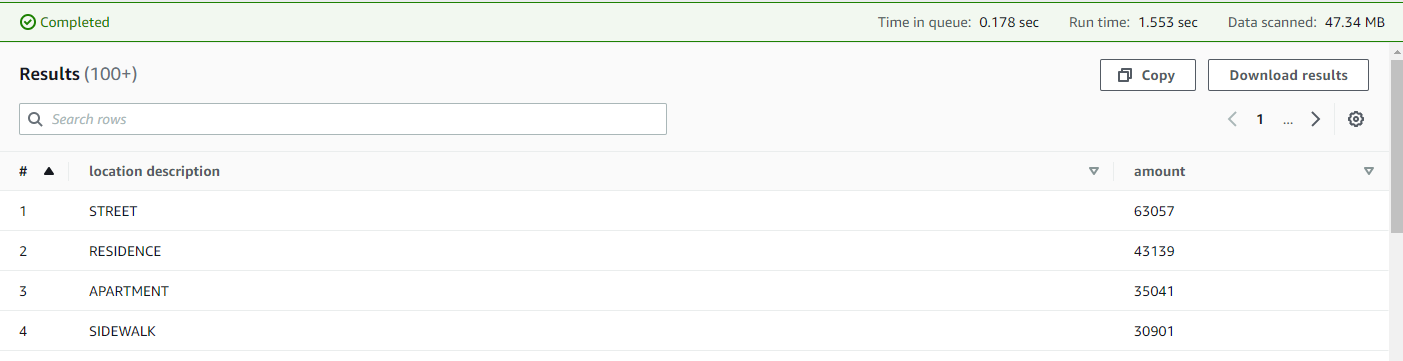

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
GROUP BY 1
ORDER BY 2 DESC;
```

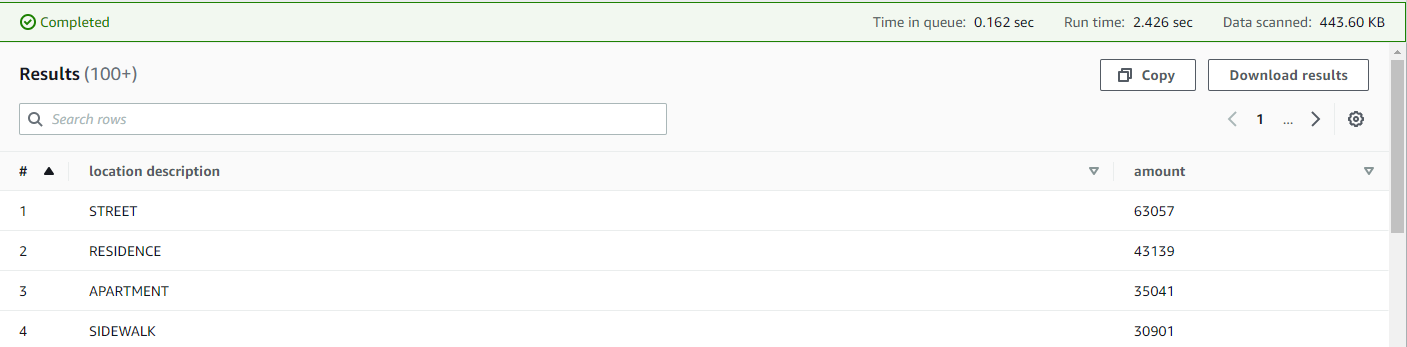

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 0.44 MB. Ou seja, a tabela com o dado **orientado a coluna** escaneou **108 vezes** menos dados para a consulta SQL que seu par em `csv`. 

 - Efeito do **particionamento**:

```sql
SELECT *
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

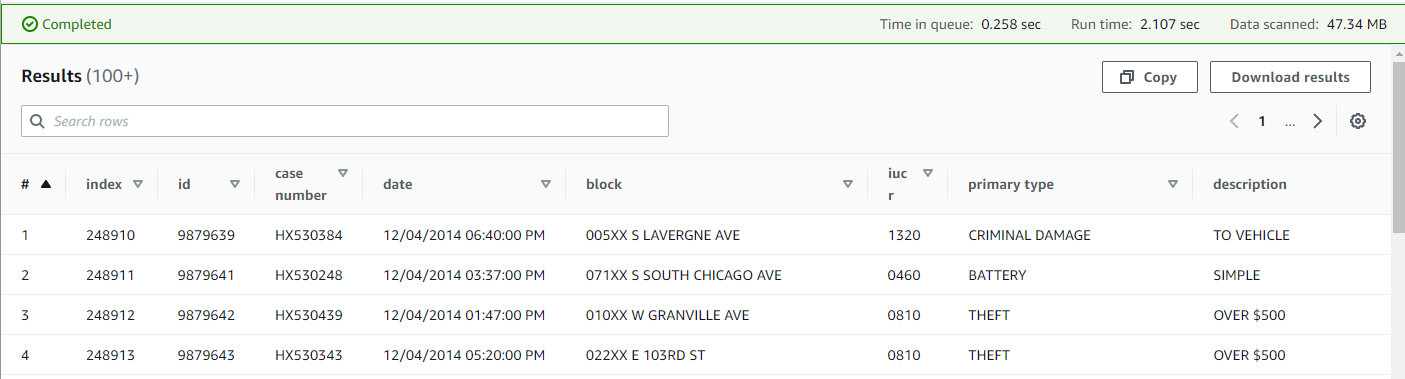

```sql
SELECT *
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

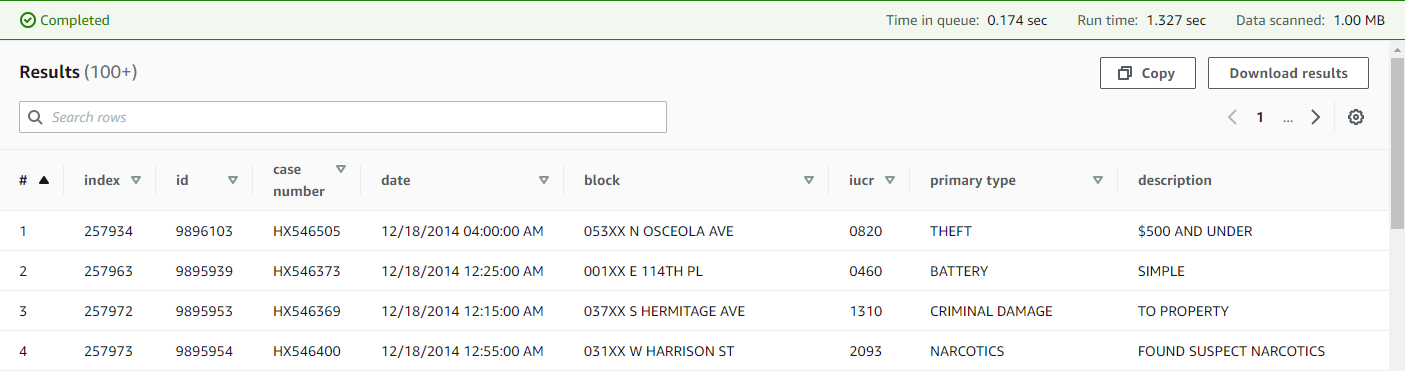

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 1.00 MB. Ou seja, a tabela com o dado **particionado** escaneou **47.34 vezes** menos dados para a consulta SQL que seu par em `csv`. 

 - Efeito da **orientação a coluna** e do **particionamento**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

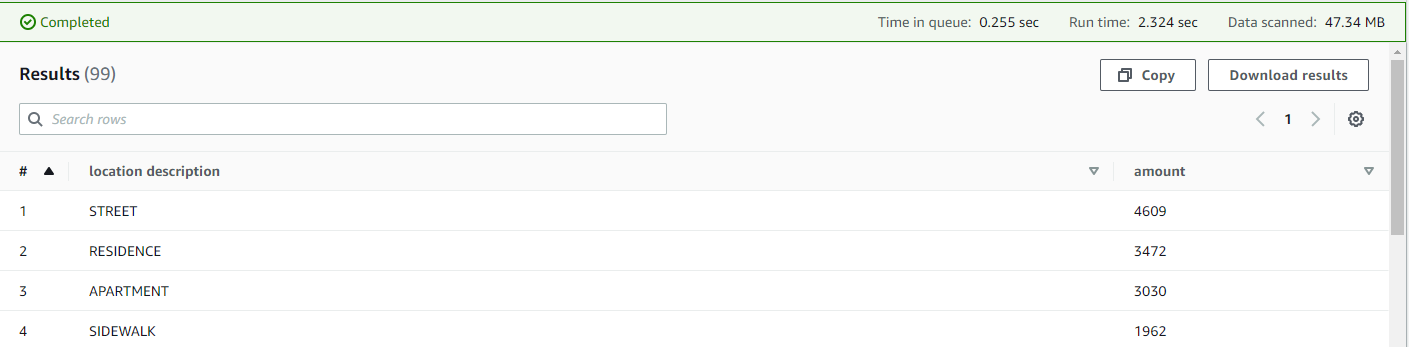

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

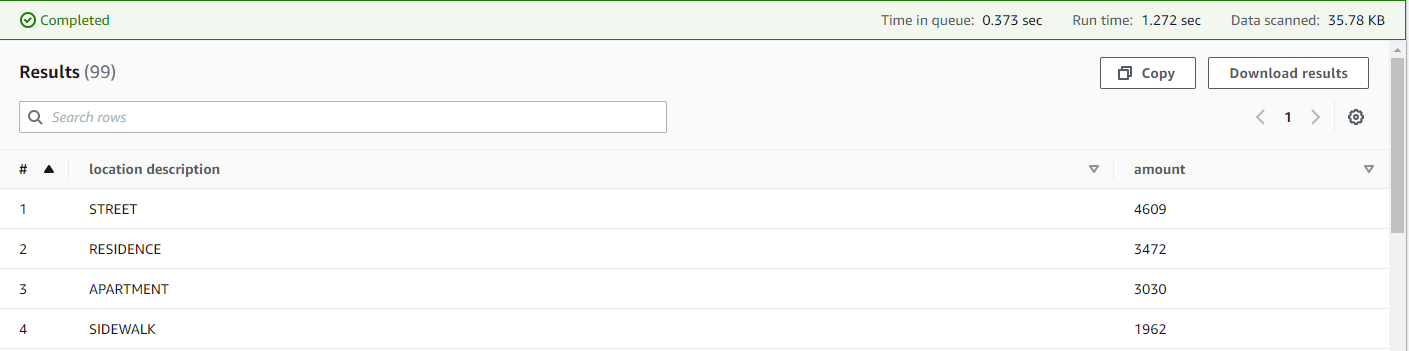

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 0.04 MB. Ou seja, a tabela com o dado **particionado** e **orientado a coluna** escaneou **1183.5 vezes** menos dados para a consulta SQL que seu par em `csv`. 